In [1]:
import tensorflow as tf

In [19]:
from google.colab import drive
drive.mount('/content/drive')


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print(tf.config.experimental.list_logical_devices('GPU'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


# Model Defination

Layer Defination

In [3]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Encoder, self).__init__()
    
    self.sep1 = tf.keras.layers.SeparableConv2D(int(filters / 4), [5,5], strides=[1,1], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [5,5], strides=[1,1], padding='same')

  def call(self, input):
    output = self.sep1(input)
    output = self.sep2(output)

    return output + input

class Downsample(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Downsample, self).__init__()

    self.sep1 = tf.keras.layers.SeparableConv2D(int(filters / 4), [5,5], strides=[2,2], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [5,5], strides=[1,1], padding='same')
    self.sep3 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[2,2], padding='same')
  
  def call(self, input):
    out1 = self.sep1(input)
    out1 = self.sep2(out1)

    out2 = self.sep3(input)
    
    return out1 + out2

class Decoder(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Decoder, self).__init__()

    self.sep1 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[1,1], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[1,1], padding='same')

  def call (self, input):
    out1 = self.sep1(input)
    out1 = self.sep2(out1)

    return out1 + input

class Upsample(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Upsample, self).__init__()
    self.deconv = tf.keras.layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same')

  def call (self, input):
    output = self.deconv(input)

    return output  

Model Defination

In [4]:
class DenoiseNetwork(tf.keras.Model):
  def __init__(self):
    super(DenoiseNetwork, self).__init__()

    # Input stage
    self.input_stage = tf.keras.layers.Conv2D(16, (3,3), padding="same", input_shape=(512,512,3))

    # Encoder Stage 1
    self.encoder_stage1 = tf.keras.Sequential([
        Downsample(64),
        Encoder(64)                       
    ])

    # Encoder Stage 2
    self.encoder_stage2 = tf.keras.Sequential([
        Downsample(128),
        Encoder(128)                       
    ])

    # Encoder Stage 3
    self.encoder_stage3 = tf.keras.Sequential([
        Downsample(256),
        Encoder(256),
        Encoder(256),
        Encoder(256)                      
    ])

    # Encoder Stage 4
    self.encoder_stage4 = tf.keras.Sequential([
        Downsample(512),
        Encoder(512),
        Encoder(512),
        Encoder(512)                      
    ])

    # Decoder Stage 1
    self.decoder_stage1 = tf.keras.Sequential([
        Decoder(512),
        Upsample(64)
    ])

    # Decoder Stage 2
    self.decoder_stage2 = tf.keras.Sequential([
        Decoder(64),
        Upsample(32)
    ])
    # Decoder Stage 3
    self.decoder_stage3 = tf.keras.Sequential([
        Decoder(32),
        Upsample(32)
    ])
    # Decoder Stage 4
    self.decoder_stage4 = tf.keras.Sequential([
        Decoder(32),
        Upsample(16)
    ])

    # Separatable Convolution
    self.sep1 = tf.keras.layers.SeparableConv2D(16, (3,3), padding='same')
    self.sep2 = tf.keras.layers.SeparableConv2D(32, (3,3), padding='same')
    self.sep3 = tf.keras.layers.SeparableConv2D(32, (3,3), padding='same')
    self.sep4 = tf.keras.layers.SeparableConv2D(64, (3,3), padding='same')

    # Output Stage
    self.output_stage = tf.keras.Sequential([
        Decoder(16),
        tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding='same')
    ])

  def call(self, input):

    out_i = self.input_stage(input)
    out_e1 = self.encoder_stage1(out_i)
    out_e2 = self.encoder_stage2(out_e1)
    out_e3 = self.encoder_stage3(out_e2)
    out_e4 = self.encoder_stage4(out_e3)

    out_d1 = self.decoder_stage1(out_e4) + self.sep4(out_e3)
    out_d2 = self.decoder_stage2(out_d1) + self.sep3(out_e2)
    out_d3 = self.decoder_stage3(out_d2) + self.sep2(out_e1)
    out_d4 = self.decoder_stage4(out_d3) + self.sep1(out_i)
    output = self.output_stage(out_d4) + input

    return output

Create and Buil Model

In [5]:
model = DenoiseNetwork()
model.build((None,512,512,3))
len(model.weights)

138

# Loss Function and Train_step

In [6]:
def loss_function(y_ground_truth, y_pred):
  return tf.reduce_sum(tf.reduce_mean(tf.abs(y_pred - y_ground_truth), axis=0))

In [7]:
def train_step(model, optimizer, clean_img, noisy_img):

  variables = model.variables
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    
    tape.watch(variables)
    y_pred = model(noisy_img)
    loss = loss_function(clean_img, y_pred)

  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))

  return loss

In [8]:
import sys

def progress(epoch, trained_sample ,total_sample, bar_length=25, loss=0, message=""):
  percent = float(trained_sample) / float(total_sample)
  hashes = '#' * int(tf.round(percent * bar_length))
  spaces = ' ' * (bar_length - len(hashes))
  sys.stdout.write("\rEpoch {0}: [{1}] {2}%  ----- Loss: {3}".format(epoch, hashes + spaces, int(round(percent * 100)), float(loss)) + message)
  sys.stdout.flush()

In [9]:
def fit(model, lr, clean_imgs, noisy_imgs, epochs):
  history = []
  optimizer = tf.keras.optimizers.Adam(lr)
  for e in range(epochs):
    total_loss = [1]
    for ite, (clean_img, noisy_img) in tf.data.Dataset.zip((clean_imgs, noisy_imgs)).enumerate():

      loss = train_step(model, optimizer, clean_img, noisy_img)
      progress(e+1, (ite+1), len(clean_imgs), loss=loss)
      total_loss.append(loss)
    history.append(sum(total_loss) / len(total_loss))
    print("\n Epoch {0}: --- Avg Loss: {1}".format(e+1, sum(total_loss) / len(total_loss)))
  return history

# Load Data

In [17]:
def load_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, 3)
  img = tf.cast(img, tf.float32)
  # img = tf.image.resize(img, [512, 512])
  return img / 255.0

BATCH_SIZE = 16

data_path1 = "/content/drive/My Drive/Data/sidd_rgb1/"
data_path2 = "/content/drive/My Drive/Data/sidd_rgb2/"

BATCH_SIZE = 8

clean_path1 = tf.data.Dataset.list_files(data_path1 + '/clean/*.png', shuffle=False)
noisy_path1 = tf.data.Dataset.list_files(data_path1 + '/noisy/*.png', shuffle=False)

clean_path2 = tf.data.Dataset.list_files(data_path2 + '/clean/*.png', shuffle=False)
noisy_path2 = tf.data.Dataset.list_files(data_path2 + '/noisy/*.png', shuffle=False)

clean_path = clean_path1.concatenate(clean_path2)
noisy_path = noisy_path1.concatenate(noisy_path2)

clean_imgs = clean_path.map(lambda x: load_image(x)).batch(BATCH_SIZE)
noisy_imgs = noisy_path.map(lambda x: load_image(x)).batch(BATCH_SIZE)

Train with first 20 epochs

In [ ]:
history = fit(model, 1e-3, clean_imgs, noisy_imgs, 20)

Epoch 1: [#########################] 100%  ----- Loss: 6180.927734375
 Epoch 1: --- Avg Loss: 6680.73388671875
Epoch 2: [#########################] 100%  ----- Loss: 6098.9521484375
 Epoch 2: --- Avg Loss: 4344.837890625
Epoch 3: [#########################] 100%  ----- Loss: 6162.5419921875
 Epoch 3: --- Avg Loss: 4040.492919921875
Epoch 4: [#########################] 100%  ----- Loss: 6165.201171875
 Epoch 4: --- Avg Loss: 3856.072509765625
Epoch 5: [#########################] 100%  ----- Loss: 6453.93896484375
 Epoch 5: --- Avg Loss: 3674.99267578125
Epoch 6: [#########################] 100%  ----- Loss: 6257.0380859375
 Epoch 6: --- Avg Loss: 3601.1455078125
Epoch 7: [#########################] 100%  ----- Loss: 5604.1357421875
 Epoch 7: --- Avg Loss: 3342.703857421875
Epoch 8: [#########################] 100%  ----- Loss: 5400.5791015625
 Epoch 8: --- Avg Loss: 3162.960693359375
Epoch 9: [#########################] 100%  ----- Loss: 5147.63134765625
 Epoch 9: --- Avg Loss: 3018.811

In [11]:
# Save weight
model.load_weights("/content/drive/My Drive/Raw Image Denoising/Weights/ckpt")

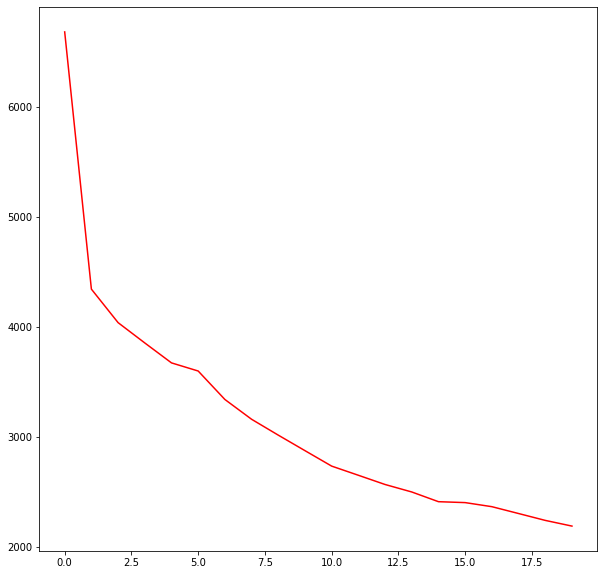

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(range(len(history)), history, 'r-')

In [12]:
source = iter(noisy_imgs).next()
target = iter(clean_imgs).next()

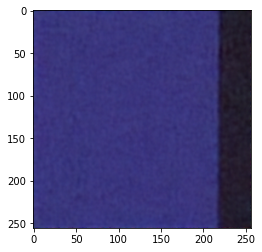

In [16]:
import matplotlib.pyplot as plt

pred = model(source)
img = pred[0]
plt.imshow(img)